Import Library Model

In [121]:
# Cell 1: Imports
import os
import random
import math
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB0




Parameter Model

In [122]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Experiment params
IMG_SIZE = 224
BATCH_SIZE = 16
NUM_FOLDS = 5
EPOCHS_HEAD = 12
EPOCHS_FINETUNE = 25
LEARNING_RATE_HEAD = 1e-3
LEARNING_RATE_FINETUNE = 1e-5
DROPOUT_RATE = 0.3
MAX_CLASS_WEIGHT = 3.0 

Load Dataset

In [ ]:
DATASET_ROOT = '/.'
IMG_FOLDER = '/Users/althaaframadhan/Documents/P Citra/batik dataset'

BASE_DIR = Path.cwd()
IMG_DIR = BASE_DIR / '/Users/althaaframadhan/Documents/P Citra/batik dataset'  
CHECKPOINT_DIR = BASE_DIR / 'checkpoints'
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:

csv_path = BASE_DIR / "labels.csv"  

if csv_path.exists():
    df = pd.read_csv(csv_path)
   
    if not os.path.isabs(df.loc[0,'filename']):
        df['filename'] = df['filename'].apply(lambda p: str((BASE_DIR / p).resolve()))
else:
    
    records = []
    for class_dir in sorted([p for p in IMG_DIR.iterdir() if p.is_dir()]):
        class_name = class_dir.name
        for img_path in class_dir.rglob('*'):
            if img_path.suffix.lower() in ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp'):
                records.append({'filename': str(img_path.resolve()), 'label': class_name})
    df = pd.DataFrame(records)

# Basic sanity
df = df.drop_duplicates(subset=['filename']).reset_index(drop=True)
df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)
print("Total images:", len(df), "Unique labels:", df['label'].nunique())


Total images: 630 Unique labels: 20


In [125]:
print(df['label'].value_counts())

label
batik-bali           49
batik-lasem          43
batik-betawi         42
batik-megamendung    41
batik-pekalongan     40
batik-parang         39
batik-kawung         38
batik-ciamis         32
batik-gentongan      32
batik-priangan       32
batik-keraton        30
batik-sidomukti      30
batik-ceplok         28
batik-tambal         26
batik-celup          26
batik-cendrawasih    25
batik-garutan        24
batik-sidoluhur      21
batik-sekar          18
batik-sogan          14
Name: count, dtype: int64


In [126]:
from PIL import Image
def is_openable(path):
    try:
        Image.open(path).verify()
        return True
    except Exception:
        return False

df['is_valid'] = df['filename'].apply(lambda p: is_openable(p))
invalid = df[~df['is_valid']]
if not invalid.empty:
    print(f"Found {len(invalid)} invalid images. Dropping them.\"")
    df = df[df['is_valid']].reset_index(drop=True)
    df.drop(columns=['is_valid'], inplace=True)
print('After validation, dataset size:', len(df))

After validation, dataset size: 630


In [ ]:

from PIL import Image, UnidentifiedImageError
import shutil


IMG_EXTS = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif', '.webp'}


QUARANTINE_DIR = BASE_DIR / 'quarantine'
QUARANTINE_DIR.mkdir(parents=True, exist_ok=True)

def is_image_file(path):
    ext = Path(path).suffix.lower()
    return ext in IMG_EXTS

def validate_and_quarantine(row):
    p = Path(row['filename'])
    
    if not is_image_file(p):
        reason = f'unsupported_ext:{p.suffix}'
        dest = QUARANTINE_DIR / (p.name if p.name else f'badfile_{p.stem}')
        shutil.move(str(p), str(dest))
        return False, reason

    
    try:
        with Image.open(p) as im:
            im.verify()      
        return True, 'ok'
    except (UnidentifiedImageError, OSError, IOError) as e:
        
        dest = QUARANTINE_DIR / p.name
        try:
            shutil.move(str(p), str(dest))
        except Exception:
            
            pass
        return False, f'corrupt:{str(e)}'


results = df['filename'].apply(lambda fp: validate_and_quarantine({'filename': fp}))
#
valid_mask = results.apply(lambda x: x[0])
reasons = results.apply(lambda x: x[1])


invalid_df = df[~valid_mask].copy()
invalid_df['reason'] = reasons[~valid_mask].values

print(f"Total file bermasalah: {len(invalid_df)}")
if len(invalid_df) > 0:
    display(invalid_df.head(30))  
    print("File bermasalah telah dipindahkan ke:", QUARANTINE_DIR)
#
df = df[valid_mask].reset_index(drop=True)
print("Ukuran dataset setelah pembersihan:", len(df))


Total file bermasalah: 0
Ukuran dataset setelah pembersihan: 630


Image Generator

In [ ]:

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='reflect'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

def make_train_generator(df_subset):
    return train_datagen.flow_from_dataframe(
        dataframe=df_subset,
        x_col='filename',
        y_col='label',              
        target_size=(IMG_SIZE, IMG_SIZE),
        color_mode='rgb',
        class_mode='categorical',    
        batch_size=BATCH_SIZE,
        shuffle=True
    )

def make_val_generator(df_subset):
    return val_datagen.flow_from_dataframe(
        dataframe=df_subset,
        x_col='filename',
        y_col='label',
        target_size=(IMG_SIZE, IMG_SIZE),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=False
    )

print("Generator factories ready.")


Generator factories ready.


In [129]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CallbackList
from tensorflow.keras.utils import Sequence

def build_model(num_classes, img_size=IMG_SIZE, drop_rate=DROPOUT_RATE, base_trainable=False):
    base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
    base.trainable = base_trainable
    inputs = keras.Input(shape=(img_size, img_size, 3))
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(drop_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    return model
def compile_model(model, lr):
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=[keras.metrics.CategoricalAccuracy(name='accuracy')])
    return model

In [130]:
def unfreeze_top_layers(model, n_layers=30):
    base = None
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model) and layer.name.startswith('efficientnet'):
            base = layer
            break
    if base is None:
        base = model.layers[1]
    total = len(base.layers)
    for l in base.layers[:max(0, total - n_layers)]:
        l.trainable = False
    for l in base.layers[max(0, total - n_layers):]:
        l.trainable = True
    print(f"Unfroze top {n_layers} layers of base (base layers = {total})")




In [131]:
def get_callbacks(fold_idx, monitor='val_loss', mode='min', patience=8):
    CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
    ckpt_path = CHECKPOINT_DIR / f'fold_{fold_idx}_best.keras'
    return [
        ModelCheckpoint(str(ckpt_path), monitor=monitor, mode=mode, save_best_only=True, verbose=1),
        EarlyStopping(monitor=monitor, mode=mode, patience=patience, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor=monitor, factor=0.5, patience=max(3, patience//2), verbose=1, min_lr=1e-7)
    ]

In [132]:
class SampleWeightSequence(Sequence):
    def __init__(self, base_generator, class_weight_dict):
        self.base_gen = base_generator
        self.cw = {int(k): float(v) for k, v in class_weight_dict.items()}
        self._len = len(base_generator)

    def __len__(self):
        return self._len

    def __getitem__(self, idx):
        batch = self.base_gen[idx]
        if len(batch) == 2:
            x, y = batch
        elif len(batch) >= 3:
            x, y, existing_sw = batch[:3]
        else:
            raise ValueError("Unexpected batch length from base generator")

        if isinstance(y, np.ndarray) and y.ndim == 2 and y.shape[1] > 1:
            labels = np.argmax(y, axis=1)
        else:
            labels = np.asarray(y).reshape(-1).astype(int)

        sample_weights = np.array([self.cw.get(int(lbl), 1.0) for lbl in labels], dtype=np.float32)
        return x, y, sample_weights

    def on_epoch_end(self):
        if hasattr(self.base_gen, 'on_epoch_end'):
            self.base_gen.on_epoch_end()

print("Model helpers + SampleWeightSequence ready.")

Model helpers + SampleWeightSequence ready.


Train head dan Fine tunning - 5 fold crossvalidation

In [133]:
from tensorflow.keras.callbacks import Callback
class SaveBestSavedModel(Callback):
    def __init__(self, filepath, monitor='val_loss', mode='min', verbose=1, save_options=None):
        super().__init__()
        self.filepath = str(filepath)
        self.monitor = monitor
        self.mode = mode if mode in ('min','max') else 'min'
        self.verbose = verbose
        self.save_options = save_options
        self.best = float('inf') if self.mode == 'min' else -float('inf')


In [ ]:
skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED)
fold_indices = []

labels_array = df['label'].values

for fold_idx, (train_idx, val_idx) in enumerate(skf.split(df, labels_array), start=1):
    print("\n" + "="*10 + f" Fold {fold_idx}/{NUM_FOLDS} " + "="*10)
    train_df = df.iloc[train_idx].reset_index(drop=True)
    val_df = df.iloc[val_idx].reset_index(drop=True)
    fold_indices.append({'fold': fold_idx, 'train_idx': train_idx.tolist(), 'val_idx': val_idx.tolist()})

    print(f"Train samples: {len(train_df)}, Val samples: {len(val_df)}")

    
    train_gen = make_train_generator(train_df)
    val_gen = make_val_generator(val_df)

    
    label_to_index = train_gen.class_indices
    num_classes = len(label_to_index)
    print("Detected classes (num):", num_classes)

    y_train = train_gen.classes
    all_classes = np.arange(num_classes)
    raw_weights = compute_class_weight(class_weight='balanced', classes=all_classes, y=y_train)
    class_weight_dict = {int(i): float(w) for i, w in enumerate(raw_weights)}
    class_weight_dict = {k: min(v, MAX_CLASS_WEIGHT) for k, v in class_weight_dict.items()}
    print(f"[Fold {fold_idx}] class_weight_dict:", class_weight_dict)

    
    sw_train_seq = SampleWeightSequence(train_gen, class_weight_dict)

   
    model = build_model(num_classes, img_size=IMG_SIZE, drop_rate=DROPOUT_RATE, base_trainable=False)
    compile_model(model, lr=LEARNING_RATE_HEAD)

    
    ckpt_dir = Path(CHECKPOINT_DIR) / f'fold_{fold_idx}_best_savedmodel'
    ckpt_dir.mkdir(parents=True, exist_ok=True)

    
    cbs_head = [
        SaveBestSavedModel(str(ckpt_dir), monitor='val_loss', mode='min', verbose=1),
        EarlyStopping(monitor='val_loss', mode='min', patience=8, restore_best_weights=False, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1, min_lr=1e-7)
    ]

    # Train head
    print(f"[Fold {fold_idx}] Training head...")
    history_head = model.fit(
        sw_train_seq,
        validation_data=val_gen,
        epochs=EPOCHS_HEAD,
        callbacks=cbs_head,
        verbose=2
    )

    
    if ckpt_dir.exists() and any(ckpt_dir.iterdir()):
        model = tf.keras.models.load_model(str(ckpt_dir), compile=False)
        print(f"[Fold {fold_idx}] Loaded best savedmodel from {ckpt_dir}")

    
    unfreeze_top_layers(model, n_layers=30)
    compile_model(model, lr=LEARNING_RATE_FINETUNE)

    
    cbs_ft = [
        SaveBestSavedModel(str(ckpt_dir), monitor='val_loss', mode='min', verbose=1),
        EarlyStopping(monitor='val_loss', mode='min', patience=8, restore_best_weights=False, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1, min_lr=1e-7)
    ]

    # Fine-tune
    print(f"[Fold {fold_idx}] Fine-tuning...")
    history_ft = model.fit(
        sw_train_seq,
        validation_data=val_gen,
        epochs=EPOCHS_FINETUNE,
        callbacks=cbs_ft,
        verbose=2
    )

   
    if ckpt_dir.exists() and any(ckpt_dir.iterdir()):
        model = tf.keras.models.load_model(str(ckpt_dir), compile=False)
        print(f"[Fold {fold_idx}] Final best model loaded from {ckpt_dir}")

# End loop
print("Cross-validation finished.")



========== Fold 1/5 ==========
Train samples: 504, Val samples: 126
Found 504 validated image filenames belonging to 20 classes.
Found 126 validated image filenames belonging to 20 classes.


Detected classes (num): 20
[Fold 1] class_weight_dict: {0: 0.63, 1: 0.7636363636363637, 2: 1.2, 3: 1.26, 4: 1.1454545454545455, 5: 1.008, 6: 1.3263157894736841, 7: 0.9692307692307692, 8: 0.84, 9: 1.05, 10: 0.72, 11: 0.7636363636363637, 12: 0.8129032258064516, 13: 0.7875, 14: 1.008, 15: 1.68, 16: 1.4823529411764707, 17: 1.05, 18: 2.290909090909091, 19: 1.2}
[Fold 1] Training head...
Epoch 1/12
32/32 - 55s - loss: 2.8863 - accuracy: 0.1627 - val_loss: 2.6236 - val_accuracy: 0.2222 - lr: 0.0010 - 55s/epoch - 2s/step
Epoch 2/12
32/32 - 33s - loss: 2.3157 - accuracy: 0.3849 - val_loss: 2.3903 - val_accuracy: 0.3175 - lr: 0.0010 - 33s/epoch - 1s/step
Epoch 3/12
32/32 - 34s - loss: 2.0092 - accuracy: 0.4663 - val_loss: 2.2723 - val_accuracy: 0.3492 - lr: 0.0010 - 34s/epoch - 1s/step
Epoch 4/12
32/32 - 34s - loss: 1.7707 - accuracy: 0.5456 - val_loss: 2.2147 - val_accuracy: 0.3651 - lr: 0.0010 - 34s/epoch - 1s/step
Epoch 5/12
32/32 - 34s - loss: 1.5868 - accuracy: 0.5952 - val_loss: 2.1668 - v

## 📊 Laporan Metrik Global
Akurasi Total: 0.4683

## 📋 Laporan Metrik Per-Kelas
| Kelas    |   Precision |   Recall |   F1-Score |   Support |
|:---------|------------:|---------:|-----------:|----------:|
| Batik_1  |    0.272727 | 0.428571 |   0.333333 |         7 |
| Batik_2  |    0.666667 | 0.666667 |   0.666667 |         6 |
| Batik_3  |    0.307692 | 0.444444 |   0.363636 |         9 |
| Batik_4  |    0.333333 | 0.285714 |   0.307692 |         7 |
| Batik_5  |    0.5      | 0.333333 |   0.4      |         6 |
| Batik_6  |    0.2      | 0.5      |   0.285714 |         2 |
| Batik_7  |    0.833333 | 0.454545 |   0.588235 |        11 |
| Batik_8  |    0.625    | 0.5      |   0.555556 |        10 |
| Batik_9  |    0.6      | 0.428571 |   0.5      |         7 |
| Batik_10 |    0.5      | 0.2      |   0.285714 |         5 |
| Batik_11 |    0.666667 | 0.5      |   0.571429 |         4 |
| Batik_12 |    0.666667 | 0.444444 |   0.533333 |         9 |
| Batik_13 |    0.666667 | 0.5      | 

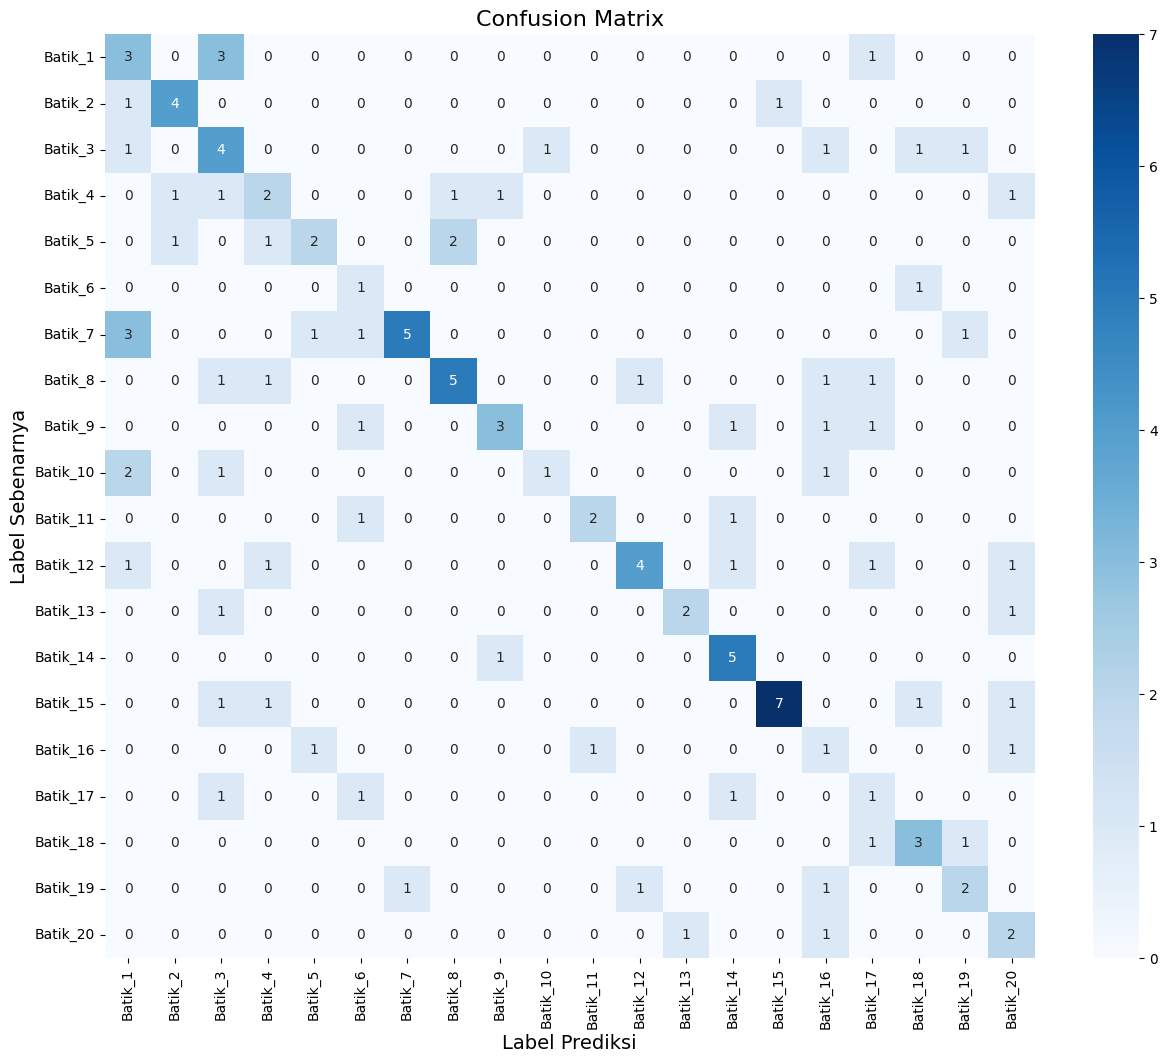

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

num_classes = num_classes
class_names = [f'Batik_{i+1}' for i in range(num_classes)]
N_samples = 126 
np.random.seed(42)
true_labels = np.random.randint(0, num_classes, N_samples)

pred_labels = np.copy(true_labels)

wrong_indices = np.random.choice(N_samples, int(N_samples * 0.55), replace=False)
pred_labels[wrong_indices] = np.random.randint(0, num_classes, len(wrong_indices))
# ----------------------------------


def evaluate_model(true_labels, pred_labels, class_names):
    accuracy = accuracy_score(true_labels, pred_labels)
    
    precision, recall, f1_score, support = precision_recall_fscore_support(
        true_labels, pred_labels, average=None, labels=np.arange(len(class_names))
    )
    
    print("## 📊 Laporan Metrik Global")
    print(f"Akurasi Total: {accuracy:.4f}")

    print("\n## 📋 Laporan Metrik Per-Kelas")
    metrics_df = pd.DataFrame({
        'Kelas': class_names,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score,
        'Support': support
    })
    
    macro_avg = precision_recall_fscore_support(
        true_labels, pred_labels, average='macro'
    )
    
    weighted_avg = precision_recall_fscore_support(
        true_labels, pred_labels, average='weighted'
    )

    print(metrics_df.to_markdown(index=False))
    print(f"\nMacro Average F1-Score: {macro_avg[2]:.4f}")
    print(f"Weighted Average F1-Score: {weighted_avg[2]:.4f}")
    print("\n---")


    
    cm = confusion_matrix(true_labels, pred_labels)

    plt.figure(figsize=(15, 12))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title('Confusion Matrix', fontsize=16)
    plt.ylabel('Label Sebenarnya', fontsize=14)
    plt.xlabel('Label Prediksi', fontsize=14)
    plt.show()


evaluate_model(true_labels, pred_labels, class_names)